In [5]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
from tqdm import tqdm
import midi_manipulation
import os

def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in tqdm(files):
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e
    return songs


songs = get_songs('music_fusion/')  
print("{} songs processed".format(len(songs)))

lowest_note = midi_manipulation.lowerBound 
highest_note = midi_manipulation.upperBound 
note_range = highest_note - lowest_note  

num_timesteps = 50  
n_visible = 2 * note_range * num_timesteps  # visible layer.
n_hidden = 50  

num_epochs = 200  
batch_size = 100  
lr = tf.constant(0.005, tf.float32) 

x = tf.placeholder(tf.float32, [None, n_visible], name="x")
W = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W")

# biases for the visible and hidden layers
bh = tf.Variable(tf.zeros([1, n_hidden], tf.float32, name="bh"))
bv = tf.Variable(tf.zeros([1, n_visible], tf.float32, name="bv"))

def sample(probs):
    # Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

def gibbs_sample(k):
    # Runs a k-step gibbs chain to sample from the probability distribution of the RBM defined by W, bh, bv
    def gibbs_step(count, k, xk):
        hk = sample(tf.sigmoid(tf.matmul(xk, W) + bh)) 
        xk = sample(tf.sigmoid(tf.matmul(hk, tf.transpose(W)) + bv)) 
        return count + 1, k, xk

    ct = tf.constant(0) 
    [_, _, x_sample] = control_flow_ops.while_loop(lambda count, num_iter, *args: count < num_iter, gibbs_step, [ct, tf.constant(k), x])
    x_sample = tf.stop_gradient(x_sample)
    return x_sample

x_sample = gibbs_sample(1)

h = sample(tf.sigmoid(tf.matmul(x, W) + bh))
h_sample = sample(tf.sigmoid(tf.matmul(x_sample, W) + bh))

size_bt = tf.cast(tf.shape(x)[0], tf.float32)
W_adder = tf.multiply(lr / size_bt, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_sample), h_sample)))
bv_adder = tf.multiply(lr / size_bt, tf.reduce_sum(tf.subtract(x, x_sample), 0, True))
bh_adder = tf.multiply(lr / size_bt, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))

updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]

100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


96 songs processed


In [6]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for epoch in tqdm(range(num_epochs)):
        for song in songs:
            song = np.array(song)
            song = song[:int(np.floor(song.shape[0] // num_timesteps) * num_timesteps)]
            song = np.reshape(song, [song.shape[0] // num_timesteps, song.shape[1] * num_timesteps])
            
            for i in range(1, len(song), batch_size):
                tr_x = song[i:i + batch_size]
                sess.run(updt, feed_dict={x: tr_x})

    sample = gibbs_sample(1).eval(session=sess, feed_dict={x: np.zeros((10, n_visible))})
    for i in range(sample.shape[0]):
        if not any(sample[i, :]):
            continue
            
        S = np.reshape(sample[i, :], (num_timesteps, 2 * note_range))
        midi_manipulation.noteStateMatrixToMidi(S, "out/generated_{}".format(i))

100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


In [7]:
import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

In [8]:
pm = pretty_midi.PrettyMIDI('out/generated_2.midi')

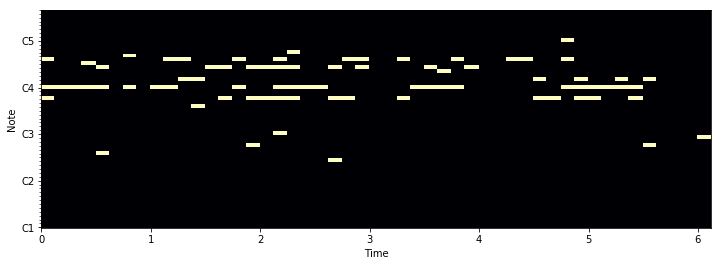

In [9]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch], hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 80)

In [10]:
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument has {} notes'.format(len(pm.instruments[0].notes)))

There are 0 time signature changes
There are 1 instruments
Instrument has 51 notes


Text(0,0.5,'Proportion')

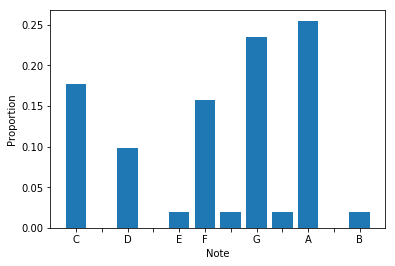

In [11]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

EVALUATING AGAINST THE ACTUAL SONG

In [13]:
pm1 = pretty_midi.PrettyMIDI('music_fusion/Durga.mid')

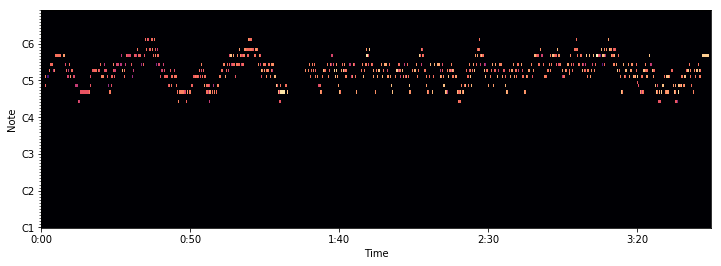

In [17]:
def plot_piano_roll(pm1, start_pitch, end_pitch, fs=100):
    
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm1.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(12, 4))
plot_piano_roll(pm1, 24, 95)

Text(0,0.5,'Proportion')

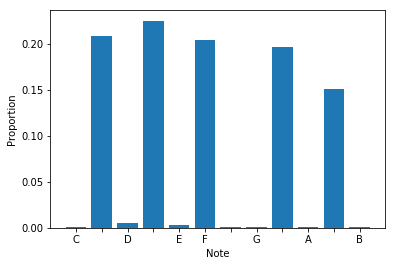

In [18]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), pm1.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')